<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Background" data-toc-modified-id="Background-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#US-Counties" data-toc-modified-id="US-Counties-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>US Counties</a></span></li><li><span><a href="#Disaster-Resilience-Components" data-toc-modified-id="Disaster-Resilience-Components-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Disaster Resilience Components</a></span></li></ul></div>

# Background

This project is based on the work of Susan L. Cutter, Christopher Burton and Christopher Emrich entitled [Disaster Resilience Indicators for Benchmarking Baseline Conditions](Cutter_jhsem.2010.7.1.1732.pdf). Click on the link to open up the paper and please give it a read. It will provide essential background for this project.

# US Counties

The dataset records in this project are indexed by county. Each county is designated a 5-digit FIPS code (https://en.wikipedia.org/wiki/FIPS_county_code). In this exercise, we walk through generating a visualization of the US counties using data provided by the US Census Bureau (https://www.census.gov/geo/maps-data/data/cbf/cbf_counties.html). It exists in the form a shapefile and is already included in this repository.

First we setup our environment:

In [1]:
import os, sys, re, json, time
import matplotlib
from copy import deepcopy
from subprocess import check_output
import netCDF4 as NC
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from ipyleaflet import Map, GeoJSON, Choropleth
from ipywidgets import Layout, link, FloatSlider, Label, VBox
from astropy.time import Time
from IPython.display import display, HTML, Markdown
from branca.colormap import linear, LinearColormap
from shapely.geometry import Point, Polygon, MultiPolygon, LineString, mapping
import geojson
import seaborn as sns

sns.set_style('white')

%matplotlib inline

Next we read in the US county shapefile into a GeoPandas dataframe:

In [2]:
def get_us_multipolygon():
    """Return multipolygon of US counties."""
    
    counties_shp = os.path.join("geo_data", "counties", "cb_2017_us_county_500k.shp")
    us = gpd.read_file(counties_shp)
    us = us.to_crs(epsg=4326) # reproject to -180, 180
    return us
    
# get geopandas data frame of US county polygons
us_polys = get_us_multipolygon()

Now that we have this dataframe, let's display it in table format:

In [3]:
display(us_polys.head())

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,01,005,00161528,0500000US01005,01005,Barbour,06,2292144656,50538698,"POLYGON ((-85.74803199999999 31.619181, -85.74..."
1,01,023,00161537,0500000US01023,01023,Choctaw,06,2365869837,19144469,"POLYGON ((-88.47322699999999 31.893856, -88.46..."
2,01,035,00161543,0500000US01035,01035,Conecuh,06,2201948618,6643480,"POLYGON ((-87.42720399999999 31.26436, -87.425..."
3,01,051,00161551,0500000US01051,01051,Elmore,06,1601762124,99965171,"POLYGON ((-86.41333499999999 32.750591, -86.37..."
4,01,065,00161558,0500000US01065,01065,Hale,06,1667907107,32423356,"POLYGON ((-87.870464 32.76244200000001, -87.86..."


Note the field names above. In particular, the `GEOID` field corresponds to the 5-digit FIPS code we discussed earlier. Let's update the dataframe to rename the `GEOID` column to `fips`, set `fips` to be the index of the dataframe. We then display the updated table:

In [4]:
us_fips = us_polys.rename(index=str, columns={"GEOID": "fips"}).set_index('fips')
display(us_fips.head())

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry
fips,,,,,,,,,
01005,01,005,00161528,0500000US01005,Barbour,06,2292144656,50538698,"POLYGON ((-85.74803199999999 31.619181, -85.74..."
01023,01,023,00161537,0500000US01023,Choctaw,06,2365869837,19144469,"POLYGON ((-88.47322699999999 31.893856, -88.46..."
01035,01,035,00161543,0500000US01035,Conecuh,06,2201948618,6643480,"POLYGON ((-87.42720399999999 31.26436, -87.425..."
01051,01,051,00161551,0500000US01051,Elmore,06,1601762124,99965171,"POLYGON ((-86.41333499999999 32.750591, -86.37..."
01065,01,065,00161558,0500000US01065,Hale,06,1667907107,32423356,"POLYGON ((-87.870464 32.76244200000001, -87.86..."


Next let's display the data on a leaflet map. First we draw a base leaflet map centered on the CONUS (continental US):

In [5]:
# zoom in on the southeastern US
m = Map(center=[31, -85], zoom=6, layout=Layout(height='600px', align_self='stretch'))
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

Now we plot the counties onto the leaflet map above (this may take a minute or two):

In [6]:
l = GeoJSON(data=us_fips.__geo_interface__,
            hover_style={'fillColor': 'red'})
m.add_layer(l)

# Disaster Resilience Components

The CSV (comma-delimited) files located under `sql/results` contain the normalized scores of each county for a particular variable. Each variable contributes to one of the 5 composite indicators or components:

1. Social Resilience
1. Economic Resilience
1. Institutional Resilience
1. Infrastructural Resilience
1. Community Resilience

Take the following CSV files for example:

In [7]:
from glob import glob

var_dir = os.path.join("sql", "results")
print("\n".join(glob("{}/*-social-*".format(var_dir))))

sql/results/11-social-educational_equity.csv
sql/results/12-social-age.csv
sql/results/13-social-transportation_access.csv
sql/results/14-social-communication_capacity.csv
sql/results/15-social-language_competency.csv
sql/results/16-social-special_needs.csv
sql/results/17-social-health_coverage.csv


These files contain the normalized scores (between 0 and 1 where a score of 0 is the worst rank for a specific indicator and 1 is the best) for each county for a particular variable that contributes to the composite score for `Social Resilience`: educational equity, age, transportation access, communication capacity, language competency, special needs, and health coverage.

Let's take a look at `sql/results/11-social-educational_equity.csv`. According to Cutter et al., education equity is the "ratio of the pct. population with college education to the pct. population with no high school diploma".

In [8]:
# disaster resilience components
drc = {}

# social resilience
drc['social'] = {}

# get dataframe from csv
df = pd.read_csv(os.path.join("sql", "results", "11-social-educational_equity.csv"))

# convert fips column from int to string and zero fill
df['fips'] = df['fips'].astype(str).str.zfill(5)

# set fips column as the index so we can join
df = df.set_index('fips').sort_index()

# save in our drc dict
drc['social']['educational_equity'] = df
display(df.head())

,measure,source,date
fips,,,
01001,0.062327,11,1/1/2016
01003,0.095348,11,1/1/2016
01005,0.019597,11,1/1/2016
01007,0.022472,11,1/1/2016
01009,0.030071,11,1/1/2016


Now let's try to visualize this data on a map. First let's add new column to the geopandas dataframe called `educational_equity`. We only add them for counties contained in the educational equity data frame:

In [9]:
# get common indexes
idx = us_fips.index.intersection(drc['social']['educational_equity'].index)
#us_fips.loc[idx]

# add education_equity column
us_fips['educational_equity'] = drc['social']['educational_equity'].loc[idx]['measure']

Next we set up the base map for our choropleth plot and a label to allow us to show information when the user hovers over a county.

In [10]:
# create a label widget
label = Label(layout=Layout(width="100%"))

# zoom in on the southeastern US
m = Map(center=[31, -85], zoom=6, layout=Layout(height='600px', align_self='stretch'))
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

Then we plot the data using the `Choropleth` function from ipyleaflet. We define a handler for the hover event so that it displays the hovered county's name and measure value for educational equity:

In [11]:
# plot
l = Choropleth(geo_data=us_fips.loc[idx].__geo_interface__,
               choro_data=us_fips.loc[idx]['educational_equity'].to_dict(),
               colormap=linear.RdBu_11,
               border_color='black',
               style={'opacity': 1, 'fillOpacity': 0.8, 'dashArray': '1'},
               hover_style={'fillColor': 'red'})

def hover_handler(event=None, id=None, properties=None):
    label.value = "County: {} | educational equity measure: {}".format(properties['NAME'],
                                                                       properties['educational_equity'])

l.on_hover(hover_handler)
m.add_layer(l)
VBox([m, label])

Hover over the counties in the map above and note the label above specifying the county name and it's education equity measure. 

The colormap we used to create the choropleth plot is a diverging colormap, `RdBu_11`, where dark red signifies values at the minimum value of 0 and dark blue signifies values at the maximum value of 1. The following image shows the `RdBu` colormap (https://matplotlib.org/tutorials/colors/colormaps.html):

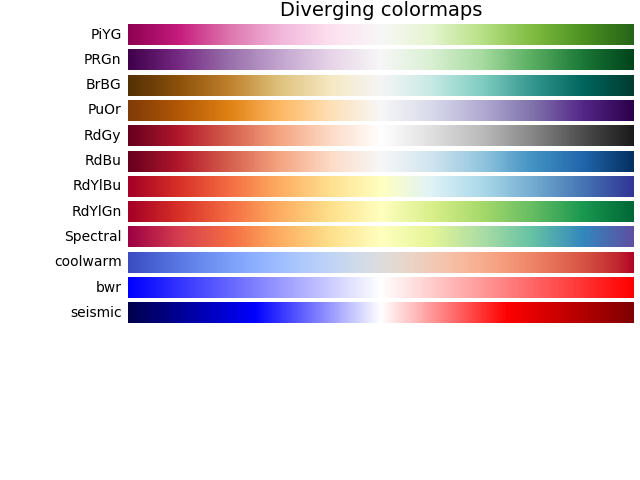

Zoom out on the leaflet map by clicking on the `-` at the top left of the map until you can see the entire CONUS (continental US). Visually, which county has the highest score for the education equity measure?

If you hover over the county that's colored closest to dark blue, you'll see that Douglas county has a score of 0.768318. Is the correct? Let's verify:

In [12]:
# sort the counties by education equity measure in descending order
us_fips_sorted = us_fips.sort_values(by=['educational_equity'], ascending=False)
display(us_fips_sorted.head())

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry,educational_equity
fips,,,,,,,,,,
51610,51,610,01498423,0500000US51610,Falls Church,25,5300264,32,"POLYGON ((-77.194712 38.899073, -77.191266 38....",0.991061
08035,08,035,00198133,0500000US08035,Douglas,06,2176069189,6950848,"POLYGON ((-105.327393 39.130873, -105.324774 3...",0.768318
31009,31,009,00835827,0500000US31009,Blaine,06,1840674086,9443894,"POLYGON ((-100.267622 42.086147, -100.167605 4...",0.726829
08091,08,091,00198161,0500000US08091,Ouray,06,1402719352,1599543,"POLYGON ((-108.13238 38.331573, -108.011681 38...",0.665589
35028,35,028,01702366,0500000US35028,Los Alamos,06,282821648,229869,"POLYGON ((-106.418546 35.820743, -106.417326 3...",0.627537


Looks like Douglas county is second only Falls Church county which has an education equity measure of 0.991061. Why didn't we see it on the map? Let's just show the top 5 counties and center on the top score. Let's draw a new map centering on the county with the top score, Falls Church:

In [13]:
# extract lon/lat of the highest score
center = us_fips_sorted.iloc[0].geometry.centroid
lon, lat = center.x, center.y

# zoom in on the southeastern US
m = Map(center=[lat, lon], zoom=10, layout=Layout(height='600px', align_self='stretch'))
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

And create a choropleth using only the top 5 scores:

In [14]:
# plot
l = Choropleth(geo_data=us_fips_sorted.head().__geo_interface__,
               choro_data=us_fips_sorted.head()['educational_equity'].to_dict(),
               colormap=linear.RdBu_11,
               border_color='black',
               style={'opacity': 1, 'fillOpacity': 0.8, 'dashArray': '1'},
               hover_style={'fillColor': 'red'})

def hover_handler(event=None, id=None, properties=None):
    label.value = "County: {} | educational equity measure: {}".format(properties['NAME'],
                                                                       properties['educational_equity'])

l.on_hover(hover_handler)
m.add_layer(l)
VBox([m, label])

As you zoom out to view all of the counties in the top 5, we see that the county of Church Falls is spatially very small in comparison to the others.

Feel free to do this sort of exploration on other variables in other disaster resilience components as well.